In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

pi = np.pi

MSME = 332948.6                            # (M_sun/M_earth)


RNRE = 3.8647      # (Rnep/Rearth)
RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)

RSRN = RSRE/RNRE   # (Rsun/Rnep)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

BIGG = 6.67e-11    # Newton's constant [SI units]

RSUN = 6.957e8     # solar radius [m]
MSUN = 1.988e30    # Solar mass [kg]

GSUN = BIGG / RSUN**3 * MSUN * (24*3600)**2    # Newton's constant [R_sun^3 * M_sun^-1 * days^-2]

# Read in CKS data

In [3]:
# READ IN CKS DATABASE
# documentation of csv file found at http://www.astro.caltech.edu/~howard/cks/column-definitions.txt

cks_file = '/Users/research/projects/maiasaurus/catalogues/clean_kepler_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

In [4]:
# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = getkey('id_starname')             # star id - 'K00082'
d['koi']         = getkey('id_koicand')
d['kic']         = getkey('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = getkey('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = getkey('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = getkey('koi_model_snr')           # transit signal-to-noise
d['npl']         = getkey('koi_count')               # number of planets in system

d['period']      = getkey('koi_period')              # period (days)
d['period_err1'] = getkey('koi_period_err1')
d['period_err2'] = getkey('koi_period_err2')

d['rprs']      = getkey('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = getkey('koi_ror_err1')
d['rprs_err2'] = getkey('koi_ror_err2')

d['impact']      = getkey('koi_impact')              # impact parameter
d['impact_err1'] = getkey('koi_impact_err1')
d['impact_err2'] = getkey('koi_impact_err2')

d['koi_duration']      = getkey('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = getkey('koi_duration_err1')
d['koi_duration_err2'] = getkey('koi_duration_err2')

d['rp']      = getkey('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = getkey('iso_prad_err1')
d['rp_err2'] = getkey('iso_prad_err2')

d['sma']      = getkey('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = getkey('iso_sma_err1')
d['sma_err2'] = getkey('iso_sma_err2')

d['rstar']      = getkey('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = getkey('iso_srad_err1')
d['rstar_err2'] = getkey('iso_srad_err2')

d['mstar']      = getkey('iso_smass')                # CKS+isochrone constrained stellar mas (solar mass)
d['mstar_err1'] = getkey('iso_smass_err1')
d['mstar_err2'] = getkey('iso_smass_err2')

d0 = d.copy()

In [5]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

total number of queried objects = 864
after removing missing data, number of objects = 864


In [6]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

# Read in masses from Andrew

In [14]:
d['mp'] = np.load('/Users/research/projects/maiasaurus/catalogues/cks_pred_masses_oct9.npy')[0]

# Calculate compexity metrics for each system

In [15]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [16]:
def P_to_a(P, Mstar):
    '''
    P: orbital periods [days]
    Mstar: stellar mass [solar masses]
    '''
    Pearth = 365.24    # [days]
    aearth = 215.05    # [solar radii]
    
    a = aearth * ((P/Pearth)**2 *(1/Mstar))**(1/3)
    
    return a

def transit_prob(a, Rstar):
    '''
    a: semi-major axis [solar radii]
    Rstar: stellar radius [solar radii]
    '''
    return Rstar/a

In [61]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    # pull planetary data
    s.rprs    = d['rprs'][d['starname']==us]
    s.masses  = d['mp'][d['starname']==us]
    s.periods = d['period'][d['starname']==us]

    # pull transit durations and errors, convert hrs to days
    s.dur     = d['koi_duration'][d['starname']==s.sysid]/24
    s.dur_err = 0.5*((d['koi_duration_err1'][d['starname']==s.sysid]) -
                     (d['koi_duration_err2'][d['starname']==s.sysid]))/24
    
    # sort masses, periods, and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.masses  = s.masses[order]
    s.periods = s.periods[order]    
    
    # calculate N and mu
    s.N  = len(s.masses)
    s.mu = np.sum(s.masses)/s.Mstar/MSME
    
    
    # some code for making a small gallery
    #if (s.mu > 1e-4)*(np.random.rand()<0.7):
    #    systems.append(s)
    #elif np.random.rand() < 0.3:
    #    systems.append(s)
    
    systems.append(s)

# Here's data for the giant moon systems & TRAPPIST-1

In [62]:
jup = System()

jup.sysid = 'Jupiter'
jup.Mstar = 9.546e-4
jup.Rstar = 0.1005
jup.rprs    = np.array([0.02604, 0.02231, 0.03762, 0.03446])
jup.masses  = np.array([0.01495, 0.008035, 0.02481, 0.01801])
jup.periods = np.array([1.769, 3.551, 7.155, 16.69])
jup.N  = len(jup.masses)
jup.mu = np.sum(jup.masses)/jup.Mstar/MSME

systems.append(jup)
uniquesys = np.hstack([uniquesys, jup])

In [63]:
sat = System()

sat.sysid = 'Saturn'
sat.Mstar = 2.858e-4
sat.Rstar = 0.0828
sat.rprs    = np.array([0.0034, 0.00432, 0.00911, 0.00963, 0.0131, 0.04417, 0.0126])
sat.masses  = np.array([6.347e-6, 1.809e-5, 1.034e-4, 1.834e-4, 3.865e-4, 2.252e-2, 3.023e-4])
sat.periods = np.array([0.942, 1.37, 1.888, 2.737, 4.518, 15.95, 79.33])
sat.N  = len(sat.masses)
sat.mu = np.sum(sat.masses)/sat.Mstar/MSME

systems.append(sat)
uniquesys = np.hstack([uniquesys, sat])

In [64]:
ura = System()

ura.sysid = 'Uranus'
ura.Mstar = 4.336e-5
ura.Rstar = 0.03646
ura.rprs    = np.array([0.0093, 0.02282, 0.02305, 0.0311, 0.03002])
ura.masses  = np.array([1.1e-5, 2.27e-4, 1.96e-4, 5.903e-4, 5.054e-4])
ura.periods = np.array([1.413, 2.25, 4.144, 8.706, 13.46])
ura.N  = len(ura.masses)
ura.mu = np.sum(ura.masses)/ura.Mstar/MSME

systems.append(ura)
uniquesys = np.hstack([uniquesys, ura])

In [21]:
trap = System()

trap.sysid = 'TRAPPIST-1'
trap.Mstar = 0.089
trap.Rstar = 0.121
trap.rprs    = np.array([1.121, 1.095, 0.784, 0.910, 1.046, 1.148, 0.773])/RSRE/trap.Rstar
trap.masses  = np.array([1.017, 1.156, 0.297, 0.772, 0.934, 1.148, 0.331])
trap.periods = np.array([1.511, 2.422, 4.050, 6.099, 9.206, 12.354, 18.768])
trap.N  = len(trap.masses)
trap.mu = np.sum(trap.masses)/trap.Mstar/MSME

systems.append(trap)
uniquesys = np.hstack([uniquesys, trap])

# Count up systems and pull out N, logmu

In [65]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu

logmu = np.log10(mu)

# Display gallery of systems

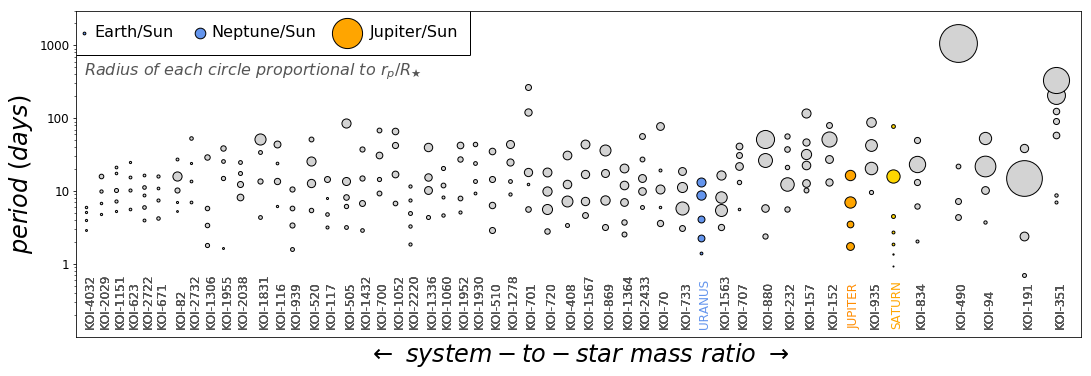

In [90]:
# determine ordering of systems
sys4 = []
mu4 = []
rp4 = []
for s in systems:
    if s.N >= 4:
        sys4.append(s)
        mu4.append(s.mu)
        rp4.append(np.max(s.rprs))

        
sys4 = np.array(sys4)
mu4  = np.array(mu4)
rp4  = np.array(rp4)

order = np.argsort(mu4)
sys4 = sys4[order]
mu4  = mu4[order]
rp4  = rp4[order]

mu_rank = np.array(stats.rankdata(mu4)-1, dtype='int')
mu_pos  = 1.5*mu_rank + 30*np.cumsum(rp4)

plt.figure(figsize=(18,6))
plt.tight_layout()

for i, s in enumerate(sys4):
    if s.sysid == 'Jupiter':
        color = 'orange'
        plt.text(mu_pos[i]-0.3, 0.13, 'JUPITER', color='darkorange', rotation=90, va='bottom', fontsize=12)
    elif s.sysid == 'Saturn':
        color = 'gold'
        plt.text(mu_pos[i]-0.3, 0.13, 'SATURN', color='orange', rotation=90, va='bottom', fontsize=12)
    elif s.sysid == 'Uranus':
        color = 'cornflowerblue'
        plt.text(mu_pos[i]-0.3, 0.13, 'URANUS', color='cornflowerblue', rotation=90, va='bottom', fontsize=12)
    #elif s.sysid == 'K00157':
    #    color = 'gold'
    #    plt.text(mu_pos[i]-0.3, 0.13, 'Kepler-11', color='orange', rotation=90, va='bottom', fontsize=12, ha='center')
    elif s.sysid == 'TRAPPIST-1':
        color = '#dd2222'
        plt.text(mu_pos[i]-0.3, 0.13, 'TRAPPIST-1', color='#dd2222', rotation=90, va='bottom', fontsize=12)
    else:
        color = 'lightgrey'
    
    for n in range(s.N):
        plt.plot(mu_pos[i], s.periods[n], 'o', markersize=300*s.rprs[n], \
                 color=color, mec='k', mew=1)
        
        if s.sysid[0] == 'K':
            plt.text(mu_pos[i]-0.3, 0.13, 'KOI-%d' %int(s.sysid[1:]), rotation=90, va='bottom', color='#555555', fontsize=12)

plt.xlim(-1,129)
plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.yscale('log')
plt.ylim(0.1,3000)
plt.yticks([1,10,100,1000], [1,10,100,1000], fontsize=12)
plt.ylabel(r'$period\ (days)$', fontsize=24)

plt.hlines(750, -1, 50, lw=1)
plt.vlines(50, 750, 3000, lw=1)
plt.plot(0, 1500, 'o', markersize=300/RSRE, color='cornflowerblue', mec='k', mew=1)
plt.text(1.3, 1500, 'Earth/Sun', va='center', fontsize=16)
plt.plot(15, 1500, 'o', markersize=300/RSRN, color='cornflowerblue', mec='k', mew=1)
plt.text(16.5, 1500, 'Neptune/Sun', va='center', fontsize=16)
plt.plot(34, 1500, 'o', markersize=300/RSRJ, color='orange', mec='k', mew=1)
plt.text(37, 1500, 'Jupiter/Sun', va='center', fontsize=16)

plt.text(0,600, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p/R_{\bigstar}$', fontsize=16, color='#555555', va='top')

#plt.savefig('/Users/research/projects/maiasaurus/Figures/gallery.eps', bbox_inches='tight')
plt.show()

In [ ]:
# determine ordering of systems
sys4 = []
mu4 = []
rp4 = []
for s in systems:
    if s.N >= 4:
        sys4.append(s)
        mu4.append(s.mu)
        rp4.append(np.max(s.rprs))

        
sys4 = np.array(sys4)
mu4  = np.array(mu4)
rp4  = np.array(rp4)

order = np.argsort(mu4)
sys4 = sys4[order]
mu4  = mu4[order]
rp4  = rp4[order]

mu_rank = np.array(stats.rankdata(mu4)-1, dtype='int')
mu_pos  = 1.5*mu_rank + 30*np.cumsum(rp4)

plt.figure(figsize=(9,6))
plt.tight_layout()

for i, s in enumerate(sys4):
    if s.sysid == 'Jupiter':
        color = 'orange'
        plt.text(mu_pos[i], s.periods.max()*1.7, 'Jupiter', color='#d15d0a', rotation=90, va='bottom', fontsize=16, ha='center')
    elif s.sysid == 'Saturn':
        color = 'gold'
        plt.text(mu_pos[i], s.periods.max()*1.7, 'Saturn', color='orange', rotation=90, va='bottom', fontsize=16, ha='center')
    elif s.sysid == 'Uranus':
        color = 'cornflowerblue'
        plt.text(mu_pos[i], s.periods.max()*1.7, 'Uranus', color='cornflowerblue', rotation=90, va='bottom', fontsize=16, ha='center')
    elif s.sysid == 'K00157':
        color = '#fff08c'
        plt.text(mu_pos[i], s.periods.max()*1.7, 'Kepler-11', color='#ffce1c', rotation=90, va='bottom', fontsize=16, ha='center')
    elif s.sysid == 'TRAPPIST-1':
        color = '#dd2222'
        plt.text(mu_pos[i], s.periods.max()*1.7, 'TRAPPIST-1', color='#dd2222', rotation=90, va='bottom', fontsize=16, ha='center')
    else:
        color = 'lightgrey'
    
    for n in range(s.N):
        plt.plot(mu_pos[i], s.periods[n], 'o', markersize=300*s.rprs[n], \
                 color=color, mec='k', mew=1)

plt.xlim(-1,77)
plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.yscale('log')
plt.ylim(0.5,3000)
plt.yticks([1,10,100,1000], [1,10,100,1000], fontsize=12)
plt.ylabel(r'$period\ (days)$', fontsize=24)

plt.hlines(750, -1, 37, lw=1)
plt.vlines(37, 750, 3000, lw=1)
plt.plot(0, 1500, 'o', markersize=300/RSRE, color='cornflowerblue', mec='k', mew=1)
plt.text(1.3, 1500, 'Earth', va='center', fontsize=16)
plt.plot(10, 1500, 'o', markersize=300/RSRN, color='cornflowerblue', mec='k', mew=1)
plt.text(11.5, 1500, 'Neptune', va='center', fontsize=16)
plt.plot(25, 1500, 'o', markersize=300/RSRJ, color='orange', mec='k', mew=1)
plt.text(28, 1500, 'Jupiter', va='center', fontsize=16)

plt.text(0,1.0, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p/R_{\bigstar}$', fontsize=16, color='dimgrey', va='top')

#plt.savefig('/Users/research/projects/maiasaurus/Figures/gallery_small.png', bbox_inches='tight')
plt.show()